In [1]:
import numpy as np
import pandas as pd
import json
import re

import collections

import matplotlib.pyplot as plt

# Parsing Helpers

In [17]:
def load_market_data(file, row_limit = None):
    md = pd.read_csv(file,sep=';')
    rename_columns = {'bid_price_1': 'bid', 'ask_price_1': 'ask', 'bid_volume_1': 'bid_sz', 'ask_volume_1': 'ask_sz'}
    md.rename(columns=rename_columns, inplace=True)
    if row_limit:
        markets = split_data_by_product(md.loc[md.timestamp <= row_limit])
    else:
        markets = split_data_by_product(md)
    symbols = list(markets.keys())
    print(f"Symbols: {symbols}")
    for s in markets:
        md_preprocess(markets[s])
    return markets

def split_data_by_product(df):
    markets = dict()
    df_grouped = df.groupby("product")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def md_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in [5, 10, 25, 50, 100]:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    md['quote_wgt_px'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/(md.bid_sz+md.ask_sz)
    for t in [1, 2, 3, 4, 5, 10, 30, 100, 200]:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'px_move_{t}'].fillna(0, inplace=True)
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)

    md['quote_imbalance'] = (md.bid_sz)/(md.bid_sz + md.ask_sz)
    
    return

In [55]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")
    empty_regex = re.compile(r"(\d+) ")
    
    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
            match = empty_regex.match(l)
            if match:
                trading_states.append(match.group(1))
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": -1, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            
    positions = pd.DataFrame(positions)
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100 or t['timestamp'] == time:
                t['true_time'] = time-100 # Duplicates will be removed and first will be kept
                market_trades.append(t)

    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return

def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)[:3]):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(3, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))[:3]):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(3, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    market_trades.drop_duplicates(subset=['price', 'quantity', 'symbol', 'timestamp'], inplace=True)
    market_trades['timestamp'] = market_trades['true_time']
    market_trades.drop(columns=['true_time'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """    
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    df['side'] = df.apply(lambda x: np.sign(x['quantity']), axis=1)
    return df

def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    
    dfs = {}
    dfs['orders'] = process_sent_orders_json(sent_orders)
    dfs['positions'] = positions
    dfs['quote'] = quote  
    dfs['order_depths'] = order_depths
    market_trades = market_trades.merge(quote, how='left', on=['timestamp','symbol'])
    own_trades = own_trades.merge(quote, how='left', on=['timestamp','symbol'])
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    
    if by_symbol:
        for table in dfs:
            dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs

# def trade_quote_join(trades, quote):
#     trades = trades.merge(quote, how='left', on=['timestamp','symbol'])
#     return trades

def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

# Data Loading

In [56]:
log_file = "logs/06956809-905b-43d7-8423-b8fe0f06d66b.log"
results_file = "results/06956809-905b-43d7-8423-b8fe0f06d66b.csv"

# log_file = "logs/ef8db0fc-7e2c-4d5a-b924-18b58ef21bcd.log"
# results_file = "results/ef8db0fc-7e2c-4d5a-b924-18b58ef21bcd.csv"
dfs = load_data_from_log(log_file)
results = load_market_data(results_file)
symbols = ['BANANAS', 'PEARLS']

Symbols: ['BANANAS', 'PEARLS']


In [57]:
dfs['orders']['PEARLS']

,price,quantity,symbol,timestamp,side
0,9998,3,PEARLS,300,1
1,10002,-1,PEARLS,500,-1
2,10002,-1,PEARLS,1500,-1
3,10002,-10,PEARLS,2900,-1
4,9998,1,PEARLS,3600,1
...,...,...,...,...,...
326,10002,-1,PEARLS,197100,-1
327,9998,1,PEARLS,197400,1
328,10002,-4,PEARLS,199400,-1
329,9998,2,PEARLS,199500,1


In [59]:
dfs['order_depths'][s]

,timestamp,symbol,bid_levels,bid,bid_sz,bid_2,bid_sz_2,bid_3,bid_sz_3,ask_levels,ask,ask_sz,ask_3,ask_sz_3,ask_2,ask_sz_2
0,0,PEARLS,2,9998.0,1,9995.0,30.0,NaN,NaN,1,10005.0,30,NaN,NaN,NaN,NaN
1,100,PEARLS,2,9996.0,1,9995.0,30.0,NaN,NaN,3,10002.0,6,10005.0,30.0,10004.0,1.0
2,200,PEARLS,2,9996.0,1,9995.0,21.0,NaN,NaN,2,10004.0,1,NaN,NaN,10005.0,21.0
3,300,PEARLS,2,9996.0,2,9995.0,23.0,NaN,NaN,3,9998.0,3,10005.0,23.0,10004.0,2.0
4,400,PEARLS,3,9998.0,5,9996.0,2.0,9995.0,23.0,2,10004.0,2,NaN,NaN,10005.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,199500,PEARLS,2,9996.0,1,9995.0,21.0,NaN,NaN,3,9998.0,2,10005.0,21.0,10004.0,1.0
1996,199600,PEARLS,1,9995.0,28,NaN,NaN,NaN,NaN,1,10005.0,28,NaN,NaN,NaN,NaN
1997,199700,PEARLS,3,10002.0,1,9996.0,2.0,9995.0,28.0,2,10004.0,2,NaN,NaN,10005.0,28.0
1998,199800,PEARLS,2,9996.0,1,9995.0,27.0,NaN,NaN,2,10004.0,1,NaN,NaN,10005.0,27.0


In [25]:
quote = dfs['order_depths'][s]

In [26]:
quote.head()

,timestamp,symbol,bid_levels,bid,bid_sz,bid_2,bid_sz_2,bid_3,bid_sz_3,ask_levels,ask,ask_sz,ask_3,ask_sz_3,ask_2,ask_sz_2
0,0,PEARLS,2,9998.0,1,9995.0,30.0,NaN,NaN,1,10005.0,30,NaN,NaN,NaN,NaN
1,100,PEARLS,2,9996.0,1,9995.0,30.0,NaN,NaN,3,10002.0,6,10005.0,30.0,10004.0,1.0
2,200,PEARLS,2,9996.0,1,9995.0,21.0,NaN,NaN,2,10004.0,1,NaN,NaN,10005.0,21.0
3,300,PEARLS,2,9996.0,2,9995.0,23.0,NaN,NaN,3,10004.0,2,9998.0,3.0,10005.0,23.0
4,400,PEARLS,3,9998.0,5,9996.0,2.0,9995.0,23.0,2,10004.0,2,NaN,NaN,10005.0,23.0


In [30]:
(quote['bid'] > 10000).any()

False

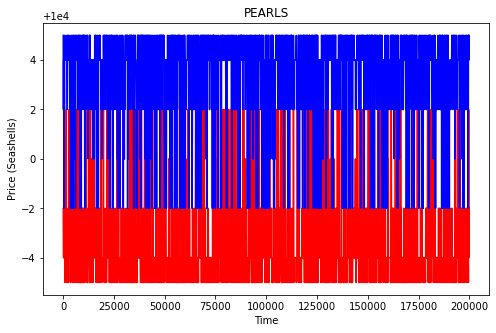

In [21]:
plot_quote(results[s], s)  


# Plotting

In [22]:
def plot_quote(md, sym):
    f, ax = plt.subplots(figsize=(8,5))
    ax.plot("timestamp", "bid", data=md, color="red")
    ax.plot("timestamp", "ask", data=md, color="blue")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (Seashells)")
    ax.set_title(sym)
    return
    
def plot_spread(md, sym):
    f, ax = plt.subplots(figsize=(8,5))
    ax.plot("timestamp", "spread", data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel("Spread")
    ax.set_title(sym)
    return

def plot_price(md, sym, price_type):
    f, ax = plt.subplots(figsize=(8,5))
    ax.plot("timestamp", price_type, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(price_type.capitalize())
    ax.set_title(sym)
    return

def plot_ohcl(md, sym):
    # Candlestick plot
    pass

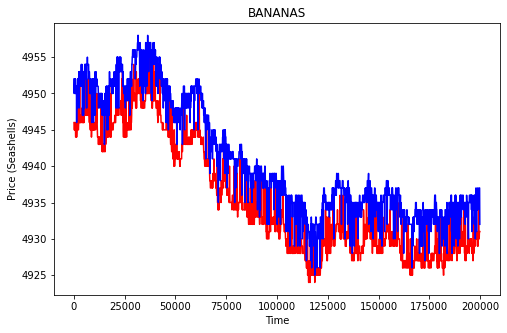

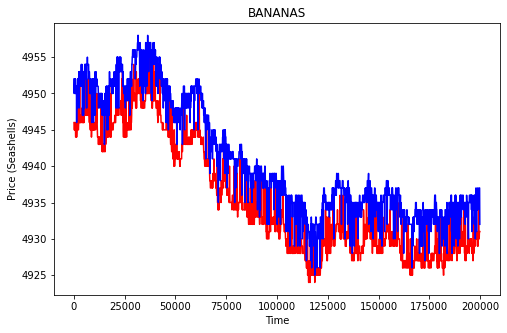

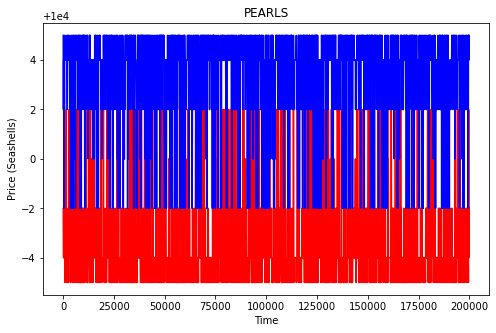

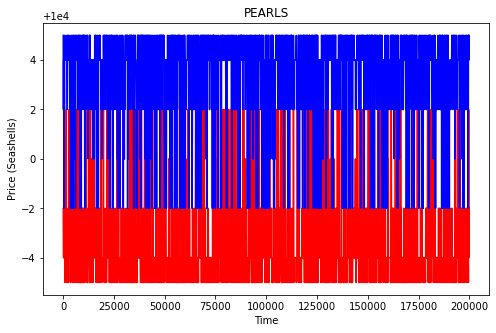

In [58]:
for s in symbols:
    plot_quote(dfs['quote'][s], s)
    plot_quote(results[s], s)
    # plot_price(markets[s], s, "mid_px_mavg10")